In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from scipy import sparse as sp

In [3]:
DATAFOLDER = "data/"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [5]:
# Pyspark related imports
import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession, SQLContext
from pyspark.mllib.linalg import Matrices

In [6]:
NUM_FEATURES = 90000
GENDER_INDEX = NUM_FEATURES + 2
AGE_INDEX = NUM_FEATURES + 1
NUM_F_SETS = 9
COLS_PER_SET = 10000
PIC_DIM = 100
FIRST_COL_OFFSET = 1
NOSE_BRIDGE_INDEX = 3

spark = SparkSession.builder.appName("Python Spark SQL basic example2").getOrCreate()
# spark.conf.set("spark.executor.memory", '50g')
# spark.conf.set('spark.executor.cores', '2')
# spark.conf.set('spark.cores.max', '2')
# spark.conf.set("spark.driver.memory",'50g')
sc = spark.sparkContext
sqlCtx = SQLContext(spark)
spark.sparkContext.setLogLevel("ERROR")

In [7]:
# Load the sparse matrices containing the image feature data
sp_face_features = None
first = True
for filename in os.listdir(DATAFOLDER):
    fn_path = os.path.join(DATAFOLDER, filename)
    b = np.load(fn_path)
    data = b['data']
    m_format = b['format']
    shape = b['shape']
    row = b['row']
    col = b['col']
    tmp = sp.csr_matrix((data, (row, col)), shape=shape)
    if first:
        sp_face_features = sp.vstack((tmp, sp_face_features), format="csr")
    else:
        sp_face_features = tmp
        first = False
print(sp_face_features.shape)

(251153, 90003)


In [8]:
def get_x_y_coord(z):
    z = z - FIRST_COL_OFFSET
    x = (z - ((z // COLS_PER_SET) * COLS_PER_SET)) % PIC_DIM
    y = (z - ((z // COLS_PER_SET) * COLS_PER_SET)) // PIC_DIM
    feature_set = z // COLS_PER_SET
    return (x, y, feature_set)

In [9]:
def get_distance_features(active_cols):
    coords = list(map(lambda z: get_x_y_coord(z), active_cols))
    np_coords = np.array(coords)
    distances = []
    nose_feature_set = np_coords[np_coords[:, 2] == NOSE_BRIDGE_INDEX]
    for i in range(0, NUM_F_SETS):
        feature_set = np_coords[np_coords[:, 2] == i]
        if i != 2:
            if len(nose_feature_set) == 0 or len(feature_set) == 0:
                distances.append((NUM_FEATURES + i, 0))
            else:
                nose_centroid = np.mean(nose_feature_set, axis=0)[0:2]
                feature_centroid = np.mean(feature_set, axis=0)[0:2]
                dist = np.linalg.norm(nose_centroid - feature_centroid)
                distances.append((NUM_FEATURES + i, dist))
    return distances

In [10]:
def get_spark_gender_dataframe_from_image_matrix(image_matrix, label_index):
    """
    Process the sparse scipy matrix with image features and return a spark dataframe with sparse vectors
    """
    spark_rows_formatted = []
    skip_count = 0
    for i, row in enumerate(image_matrix):
        active_cols = row.nonzero()[1]
        # Remove first column if index col and remove last two label columns
        if active_cols[0] == 0:
            active_cols = active_cols[1:-2]
        else:
            active_cols = active_cols[:-2]
        indexes = list(map(lambda z: (z, 1), active_cols))
        indexes += get_distance_features(active_cols)
        try:
            label = int(image_matrix[i, label_index])
            spark_rows_formatted.append((label, indexes))
        except ValueError:
            skip_count += 1
    print("Note that {} images were skipped due to nan label.".format(str(skip_count)))
    mapped_f = map(lambda x: (x[0], Vectors.sparse(NUM_FEATURES + NUM_F_SETS, x[1][1:])),
                   spark_rows_formatted)
    df_analysis = spark.createDataFrame(mapped_f, schema=["label", "features"])
    return df_analysis

In [11]:
df_gender_analysis = get_spark_gender_dataframe_from_image_matrix(sp_face_features, GENDER_INDEX)
df_gender_analysis.show(5)

Note that 5057 images were skipped due to nan label.
+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(90009,[4994,6093...|
|    1|(90009,[5121,6122...|
|    1|(90009,[3899,4705...|
|    1|(90009,[4582,5581...|
|    1|(90009,[3789,4888...|
+-----+--------------------+
only showing top 5 rows



In [12]:
# Prepare the training and test data
splits = df_gender_analysis.randomSplit([0.75, 0.25])
data_train = splits[0]
data_test = splits[1]
print("The training data has {} instances.".format(data_train.count()))
print("The test data has {} instances.".format(data_test.count()))

The training data has 184561 instances.
The test data has 61535 instances.


In [13]:
lr = LogisticRegression(maxIter=10, regParam=0.3)

In [14]:
# Fit the model
lrModel = lr.fit(data_train)
trainingSummary = lrModel.summary
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|1.918943813325145...| 0.01830007613282829|
|4.349605976870331E-4| 0.03044373220042672|
|9.466789479070719E-4| 0.04852762869737671|
|0.001253709958039...|0.055943530119462744|
|0.002072459318391...| 0.07356687000084593|
|0.002750486132432...| 0.08595490304813287|
|0.003773922832872...| 0.10289210756346752|
|0.004797359533312...| 0.11697198123936725|
| 0.00619179203766247| 0.13347682648294532|
|0.006498823047794494| 0.13677591570874023|
|0.008072356974721114| 0.15356273439042042|
|0.008763176747518166| 0.16088464466647243|
|0.010579776890799305| 0.17707931912813812|
|0.011846279807593901| 0.18816087524555186|
|0.013445399652031521|  0.2050698824170763|
|0.015082898372735647|  0.2186516030189956|
|0.017385630948725823| 0.23510005357495323|
|0.017731040835124348| 0.23712086321468517|
|  0.0197267424009825|   0.25355

In [17]:
predictions = lrModel.transform(data_test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
score = evaluator.evaluate(predictions)
#evaluator.getMetricName()
score

0.7454750713446491

In [18]:
roc = trainingSummary.roc


In [19]:
roc.select(roc['FPR']).collect()

[Row(FPR=0.0),
 Row(FPR=0.00019189438133251457),
 Row(FPR=0.0004349605976870331),
 Row(FPR=0.0009466789479070719),
 Row(FPR=0.0012537099580390953),
 Row(FPR=0.0020724593183911576),
 Row(FPR=0.0027504861324327092),
 Row(FPR=0.0037739228328727867),
 Row(FPR=0.0047973595333128645),
 Row(FPR=0.00619179203766247),
 Row(FPR=0.006498823047794494),
 Row(FPR=0.008072356974721114),
 Row(FPR=0.008763176747518166),
 Row(FPR=0.010579776890799305),
 Row(FPR=0.011846279807593901),
 Row(FPR=0.013445399652031521),
 Row(FPR=0.015082898372735647),
 Row(FPR=0.017385630948725823),
 Row(FPR=0.017731040835124348),
 Row(FPR=0.0197267424009825),
 Row(FPR=0.021377034080442125),
 Row(FPR=0.02384607512025381),
 Row(FPR=0.026046464026199978),
 Row(FPR=0.028809743117388188),
 Row(FPR=0.029820386859072765),
 Row(FPR=0.032916282877904005),
 Row(FPR=0.03599938593797974),
 Row(FPR=0.03605055777300174),
 Row(FPR=0.03929996929689899),
 Row(FPR=0.042178385016886706),
 Row(FPR=0.04582437826220448),
 Row(FPR=0.0472699826015

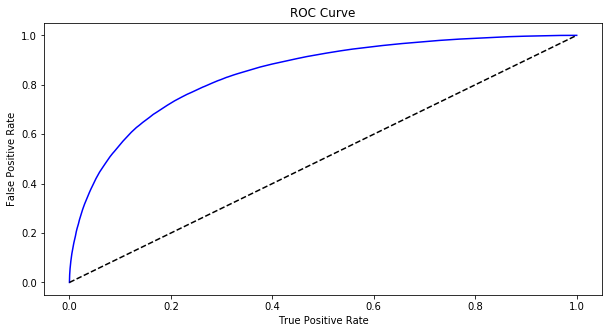

In [27]:
plt.figure(figsize=(10,5))
fpr = roc.select(roc['FPR']).collect()
tpr = roc.select(roc['TPR']).collect()
plt.plot(fpr,tpr, 'b')
plt.plot(fpr,fpr, 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
